<a href="https://colab.research.google.com/github/sterecore/HamiltonGraphs_Dataset_and_MLP/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import networkx as nx
import scipy as sci
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

##Формирование датасета##

In [ ]:
DATA_FOLDER_ID = '1nGXjykOpvlkCmApzXGC5q_thzKXOhsXN'

ROOT_PATH = '/content'
!pip install -U -q PyDrive2
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# аутентификация и создание PyDrive клиента
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# выбор локальной коллабовской директории для хранения данных
local_root_path = os.path.expanduser(ROOT_PATH)
try:
  os.makedirs(local_root_path)
except: pass

def ListFolder(google_drive_id, destination):
  file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % google_drive_id}).GetList()
  counter = 0
  for f in file_list:
    # Если это директория, то создаем директорию и загружаем в нее файлы
    if f['mimeType']=='application/vnd.google-apps.folder':
      folder_path = os.path.join(destination, f['title'])
      os.makedirs(folder_path)
      print('creating directory {}'.format(folder_path))
      ListFolder(f['id'], folder_path)
    else:
      fname = os.path.join(destination, f['title'])
      f_ = drive.CreateFile({'id': f['id']})
      f_.GetContentFile(fname)
      counter += 1
  print('{} files were uploaded in {}'.format(counter, destination))

ListFolder(DATA_FOLDER_ID, local_root_path)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 707.1 kB/s eta 0:00:00


4 files were uploaded in /content


In [ ]:
graphs = nx.read_graph6("/content/hamilton")
targets = np.array(list(list(open('/content/bools.txt'))[0])).astype(np.int64)

## Анализ данных##

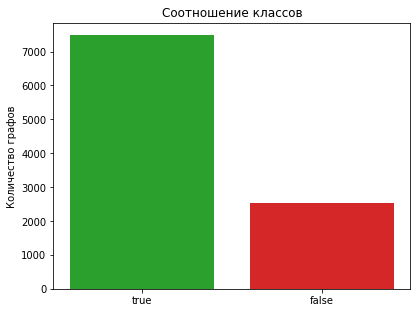

In [ ]:
fig, ax = plt.subplots(dpi = 72)

labels = ['true', 'false']
classes = [np.sum(targets), targets.shape[0] - np.sum(targets)]

ax.bar(labels, classes, color = ["tab:green", "tab:red"])

ax.set_ylabel('Количество графов')
ax.set_title('Соотношение классов')

plt.show()

Отбор данных с равновероятными классами для репрезентативной выборки

In [ ]:
false = targets.shape[0] - np.sum(targets)
normalized_graphs = []
normalized_targets = []
c = 0
for i in range(len(graphs)):
  if targets[i] == 0:
    normalized_targets.append(0)
    normalized_graphs.append(graphs[i])
  else:
    if c < false:
      c += 1
      normalized_targets.append(1)
      normalized_graphs.append(graphs[i])

## Graph to Vectors ##


In [ ]:
# иногда создание graphs.Lables не работает с первого раза и ячейку необходимо запускать несколько раз

!mkdir /content/dataset
labels = open("/content/graphs.Labels", "w")
for num, G in enumerate(normalized_graphs):
  nx.write_gexf(G, f'/content/dataset/{num}.gexf')
  string = str(num) + '.gexf '+ str(normalized_targets[num]) + '\n'
  labels.write(string)

mkdir: cannot create directory ‘/content/dataset’: File exists


Ниже представлен код, превращающий графы в эмбеддинги. Этот код почти полностью взят с гитхаба [graph2vec](https://github.com/annamalai-nr/graph2vec_tf/tree/master), однако туда пришлось внести некоторые минорные изменения, чтобы он работал на Python3 с новыми версиями библиотек

In [ ]:
!mkdir /content/src
local_root_path = os.path.expanduser('/content/src')
try:
  os.makedirs(local_root_path)
except: pass

ListFolder('1TwDrkN9MQE24MIL0k9GAw7iZDsATzpn8', local_root_path)

9 files were uploaded in /content/src


In [ ]:
%cd /content/src
!mkdir ../embeddings
!python main.py --corpus ../dataset --class_labels_file_name ../graphs.Labels -e 500 -b 32 -lr 0.1


/content/src
2024-05-18 11:58:23.335440: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 11:58:23.335511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 11:58:23.340613: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-18 11:58:23.394635: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 11:58:27.961184: W tensorflow

In [ ]:
# загрузка на диск
import shutil
from google.colab import drive
drive.mount('/content/drive')
for filename in os.listdir("/content/embeddings"):
  shutil.copy(f"/content/embeddings/{filename}", f"/content/drive/MyDrive/{DATA_FOLDER_ID}")


Mounted at /content/drive


## Обучение моделей ##

Я делала преобразование эмбеддингов и обучение модели в разных сеансах, поэтому пришлось сохранять файлы с векторами на Google Drive в папке датасета. При желании шаг загрузки с диска можно пропустить и использовать сразу же извлеченные эмбеддинги, хранящиеся в \content\embeddings\


In [ ]:
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

In [ ]:
def get_class_labels(graph_files, class_labels_fname):
    graph_to_class_label_map = {l.split()[0].split('.')[0]: int(l.split()[1].strip()) for l in open (class_labels_fname)}
    labels = [graph_to_class_label_map[os.path.basename(g).split('.')[0]] for g in os.listdir(graph_files)]
    return labels

Если ячейка ниже выдает ошибки, то стоит перезапустить [ячейку](https://colab.research.google.com/drive/1kr7Iqs7apVbBLyVIct_ePFg_DWsy5fvQ#scrollTo=Jj5DrezSo660&line=1&uniqifier=1)

In [ ]:
y = np.array(get_class_labels('/content/dataset', '/content/graphs.Labels'))

with open('/content/embeddings_128_epochs_1000_lr_0.2.txt','r') as fh:
  graph_embedding_dict = json.load(fh)
X = np.array([graph_embedding_dict['../dataset/'+fname+'.g2v3'] for fname in os.listdir('/content/dataset')])

# нормализуем данные векторов
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print('Размеры трейна и теста: {}, {}, {}, {} '.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

Размеры трейна и теста: (4287, 128), (757, 128), (4287,), (757,) 


In [ ]:
models = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(), LinearSVC(), SGDClassifier(), XGBClassifier()]
cls_names = {0: "KNeighbours", 1: "NaiveBayes", 2: "RandomForest", 3: "LinearSVC", 4:"SGD", 5:"GradientBoost"}
for i,model in enumerate(models):
  # подбор гиперпараметров
  params = {3:{'C':[0.01,0.1,1,10,100,1000]},
            0:{'n_neighbors':[10,25,50,100,250,500,1000]},
            2:{'n_estimators':[10,25,50,100,250,500,1000]},
            1:{'var_smoothing':np.logspace(0,-9, num=100)},
            4:{'alpha':[0.01,0.1,1,10,100,1000]},
            5:{'gamma':[0.01,0.1,1,10,100,1000]}}
  classifier = GridSearchCV(model, params[i], cv=5,verbose=1, n_jobs = -1)

  # обучение модели
  classifier.fit(X_train,y_train)
  print('Лучшиие гиперпараметры', classifier.best_params_)

  # прогнозы точности модели
  y_pred = classifier.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  print(f'{cls_names[i]} accuracy:{acc}')
  print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Лучшиие гиперпараметры {'n_neighbors': 25}
KNeighbours accuracy:0.8718626155878467
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       356
           1       0.96      0.80      0.87       401

    accuracy                           0.87       757
   macro avg       0.88      0.88      0.87       757
weighted avg       0.89      0.87      0.87       757

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Лучшиие гиперпараметры {'var_smoothing': 0.12328467394420659}
NaiveBayes accuracy:0.9352708058124174
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       356
           1       0.94      0.93      0.94       401

    accuracy                           0.94       757
   macro avg       0.93      0.94      0.94       757
weighted avg       0.94      0.94      0.94       757

Fitting 5 folds for each of 7 candidate

## MLP##

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [ ]:
feature_vector_length = 128
num_classes = 2

# Решейп данных
X_train = X_train.reshape(X_train.shape[0], feature_vector_length)
X_test = X_test.reshape(X_test.shape[0], feature_vector_length)

# Категоризация классов targetов
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

input_shape = (feature_vector_length,)
print(f'Размер feature: {input_shape}')

Размер feature: (128,)


In [ ]:
# Создание модели
model = Sequential()
model.add(Dense(350, input_shape=input_shape, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 350)               45150     
                                                                 
 dense_1 (Dense)             (None, 50)                17550     
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 62802 (245.32 KB)
Trainable params: 62802 (245.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Инициализация модели
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Для хранения лосса и точности модели
loss_plot = []; accA_plot = []

for epoch in range(20 + 1):
    # Обучение модели
    model.fit(X_train, y_train_cat, epochs=1, verbose=1, batch_size = 300)
    loss_plot += [e*100 for e in model.history.history['loss']]
    accA_plot += [e*100 for e in model.history.history['accuracy']]
    print(f'epoch: {epoch:04d} | loss: {loss_plot[-1]:.3f} | accuracy: {accA_plot[-1]:06.2f} %')

# Прогноз точности модели
test_results = model.evaluate(X_test, y_test_cat, verbose=1)
print(f'Результаты - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

15/15 [==============================] - 2s 10ms/step - loss: 0.0963 - accuracy: 0.9704
epoch: 0000 | loss: 9.635 | accuracy: 097.04 %
15/15 [==============================] - 0s 10ms/step - loss: 0.0182 - accuracy: 0.9921
epoch: 0001 | loss: 1.822 | accuracy: 099.21 %
15/15 [==============================] - 0s 12ms/step - loss: 0.0075 - accuracy: 0.9988
epoch: 0002 | loss: 0.745 | accuracy: 099.88 %
15/15 [==============================] - 0s 11ms/step - loss: 0.0038 - accuracy: 0.9998
epoch: 0003 | loss: 0.378 | accuracy: 099.98 %
15/15 [==============================] - 0s 11ms/step - loss: 0.0029 - accuracy: 1.0000
epoch: 0004 | loss: 0.290 | accuracy: 100.00 %
15/15 [==============================] - 0s 12ms/step - loss: 0.0027 - accuracy: 1.0000
epoch: 0005 | loss: 0.270 | accuracy: 100.00 %
15/15 [==============================] - 0s 11ms/step - loss: 0.0026 - accuracy: 0.9998
epoch: 0006 | loss: 0.259 | accuracy: 099.98 %
15/15 [==============================] - 0s 11ms/step -

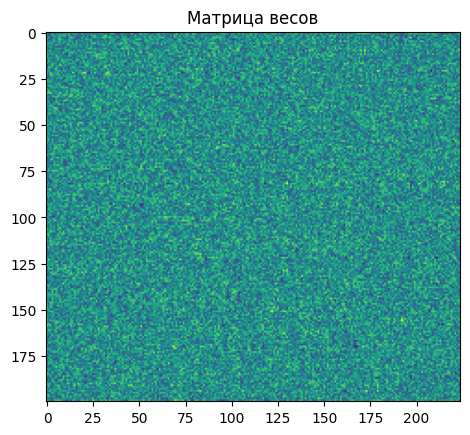

In [ ]:
w_ = model.weights[0].numpy()

ax = plt.subplot()
ax.imshow(w_.T.reshape(200, 224))
ax.set_title('Матрица весов')

plt.show()

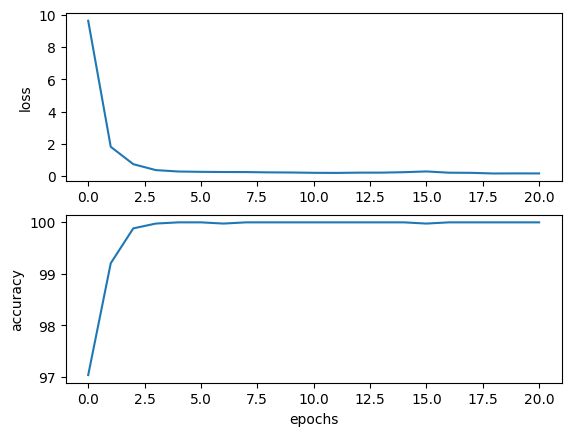

In [ ]:
ax1 = plt.subplot(211)
ax1.plot(loss_plot)
ax1.set_ylabel('loss')

ax2 = plt.subplot(212)
ax2.plot(accA_plot)
ax2.set_ylabel('accuracy')

plt.xlabel('epochs')

plt.show()